In [1]:
# Imports
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Reshape
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.callbacks import LearningRateScheduler
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import random
import math
import json

# Pinkie Pie was here

Using TensorFlow backend.


In [2]:
human_vocab_size = 1 # len(human_vocab)
machine_vocab_size = 1 # len(machine_vocab)

# Number of training examples
data_len = 1000 # len(dataset)
Tx = 32 # Max x sequence length --> input time_step
Ty = 5 # y sequence length  ---> output timestep or predict timestep
layer1_size = 4
layer2_size = 4 # Attention layer

In [3]:
# 获取数据
# ts = np.arange(data_len)/data_len
ts = []
for i in range(data_len):
#     ts.append(np.exp(-i/data_len*3))
    ts.append(np.sin(i/data_len*6)/2+0.5)
    
X = []
Y = []
for i in range(Tx,data_len-Ty):
    X_i = ts[i-Tx:i]
    Y_i = ts[i:i+Ty]
    X.append(np.array([X_i]).T)
    Y.append(np.array([Y_i]).T)
    
X = np.array(X)
Y = np.array(Y)

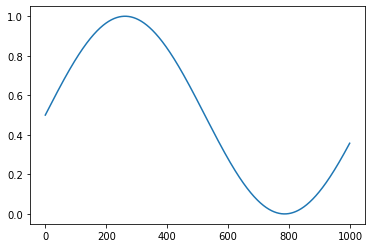

In [4]:
plt.plot(ts)

In [5]:
# 划分训练集和测试集
train_size = int(0.8*data_len)
X_train = X[:train_size]
Y_train = Y[:train_size]
X_test = X[train_size:]
Y_test = Y[train_size:]

In [6]:
X_train.shape

(800, 32, 1)

In [7]:
Y_train.shape

(800, 5, 1)

In [8]:
# Define part of the attention layer gloablly so as to
# share the same layers for each attention step.
def softmax(x):
    return K.softmax(x, axis=1)

at_repeat = RepeatVector(Tx)
at_concatenate = Concatenate(axis=-1)
at_dense1 = Dense(8, activation="tanh", init = "normal")  # 初始化方法：uniform、lecun_uniform、normal、orthogonal、zero、glorot_normal、he_normal等
at_dense2 = Dense(1, activation="relu", init = "normal")
at_softmax = Activation(softmax, name='attention_weights')
at_dot = Dot(axes=1)

def one_step_of_attention(h_prev, a):
    """
    Get the context.
    
    Input:
    h_prev - Previous hidden state of a RNN layer (m, n_h)
    a - Input data, possibly processed (m, Tx, n_a)
    
    Output:
    context - Current context (m, Tx, n_a)
    """
    # Repeat vector to match a's dimensions
    h_repeat = at_repeat(h_prev)
    # Calculate attention weights
    i = at_concatenate([a, h_repeat])
    i = at_dense1(i)
    i = at_dense2(i)
    attention = at_softmax(i)
    # Calculate the context
    context = at_dot([attention, a])
    
    return context

D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="tanh", kernel_initializer="normal")`
  
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':


In [9]:
def attention_layer(X, h0, c0, n_h, Ty):
    """
    Creates an attention layer.
    
    Input:
    X - Layer input (m, Tx, x_vocab_size)
    n_h - Size of LSTM hidden layer
    Ty - Timesteps in output sequence
    
    Output:
    output - The output of the attention layer (m, Tx, n_h)
    """    
    # Define the default state for the LSTM layer
#     h = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)))(X)  # 翻译时decoder 的初始化可以为0，也可以为encoder 的最后输出
    h = h0   # 序列预测时使y用encoder的LSTM state作为初始的state
#     c = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)))(X)  
    c = c0   # 序列预测时使y用encoder的LSTM state作为初始的state
    # Messy, but the alternative is using more Input()
    
    at_LSTM = LSTM(n_h, return_state=True)
    
    output = []
              
    # Run attention step and RNN for each output time step
    for _ in range(Ty):
        context = one_step_of_attention(h, X)
        
        h, _, c = at_LSTM(context, initial_state=[h, c])
        
        output.append(h)
        
    return output

In [10]:
# layer3 = Dense(machine_vocab_size, activation=softmax)  # 用于语义处理
layer3 = Dense(machine_vocab_size, activation="relu", init = "normal")  # 数据预测

def get_model(Tx, Ty, layer1_size, layer2_size, x_vocab_size, y_vocab_size):
    """
    Creates a model.
    
    input:
    Tx - Number of x timesteps
    Ty - Number of y timesteps
    size_layer1 - Number of neurons in BiLSTM
    size_layer2 - Number of neurons in attention LSTM hidden layer
    x_vocab_size - Number of possible token types for x
    y_vocab_size - Number of possible token types for y
    
    Output:
    model - A Keras Model.
    """
    
    # Create layers one by one
    X = Input(shape=(Tx, x_vocab_size))
    
    h0 = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], layer1_size)))(X)
    c0 = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], layer1_size)))(X) 
    a1, h1, c1 = LSTM(layer1_size, return_sequences=True, return_state = True, init = "normal")(X, initial_state=[h0, c0],)

    a2 = attention_layer(a1, h1, c1, layer2_size, Ty)
    
    a3 = [layer3(timestep) for timestep in a2]
        
    # Create Keras model
    model = Model(inputs=[X], outputs=a3)
    
    return model

D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="normal")`
  


In [11]:
# Obtain a model instance
model = get_model(Tx, Ty, layer1_size, layer2_size, human_vocab_size, machine_vocab_size)

Instructions for updating:
Colocations handled automatically by placer.


D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, return_sequences=True, return_state=True, kernel_initializer="normal")`


In [12]:
# Create optimizer
opt = Adam(lr=0.01, clipnorm=1.0) #  decay=0.04,
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

In [13]:
# Group the output by timestep, not example
outputs_train = list(Y_train.swapaxes(0,1))

In [58]:
# Time to train
# It takes a few minutes on an quad-core CPU
EPOCH = 2
outputs_test = list(Y_test.swapaxes(0,1))

for i in range(EPOCH):
    model.fit([X_train], outputs_train, epochs=1, batch_size=64)
    score = model.evaluate(X_test, outputs_test) 
    print('Test loss: ', score[0])

Epoch 1/1
163/163 [==============================] - 0s 279us/step
Test loss:  0.0016246689610294655
Epoch 1/1
163/163 [==============================] - 0s 267us/step
Test loss:  0.001188922812912236


In [44]:
# Evaluate the test performance
outputs_test = list(Y_test.swapaxes(0,1))
score = model.evaluate(X_test, outputs_test) 
print('Test loss: ', score[0])

163/163 [==============================] - 0s 307us/step
Test loss:  0.0016077523665399822


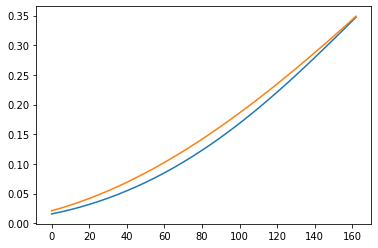

In [64]:
prediction = np.array(model.predict( X_test))

plt.plot(prediction[2,:,0])
plt.plot(Y_test.swapaxes(0,1)[2,:,0])
# plt.plot(Y_test.swapaxes(0,1)[0,:,0]-prediction[0,:,0])

In [46]:
# Let's visually check model output.
import random as random

i = random.randint(0, data_len-Ty-Ty)
i = 960

def get_prediction(model, x):
    prediction = model.predict(x)
    
    return prediction

prediction = get_prediction(model, X[i:i+1])

print("Input: " + str(X[i].T))
print("Prediction: " , np.array(prediction).swapaxes(0,2)[0][0])
print("real value: " , np.array(Y[i]).swapaxes(0,1)[0])
print("error value:" , np.array(Y[i]).swapaxes(0,1)[0]-np.array(prediction).swapaxes(0,2)[0][0])

Input: [[0.25017906 0.25278224 0.25539431 0.2580152  0.26064479 0.263283
  0.26592973 0.26858489 0.27124838 0.27392011 0.27659997 0.27928788
  0.28198373 0.28468743 0.28739889 0.29011799 0.29284465 0.29557877
  0.29832025 0.30106899 0.30382489 0.30658785 0.30935778 0.31213456
  0.31491812 0.31770833 0.32050511 0.32330834 0.32611794 0.3289338
  0.33175582 0.3345839 ]]
Prediction:  [0.3160552  0.32926172 0.3376398  0.34659165 0.35710132]
real value:  [0.33741792 0.34025781 0.34310344 0.34595472 0.34881155]
error value: [ 0.02136272  0.01099609  0.00546363 -0.00063693 -0.00828977]


### rolling predict

In [69]:
i = 1
X_test[i:i+1][0,-1,0].shape

(1, 32, 1)

In [70]:
X_test[i:i+1][0,-1,0]

0.0194185687360256

In [99]:
test_num

800

In [96]:
test_num = train_size

pred = []
for i in range(test_num,test_num+20):
    if i == test_num:
        R_test = X[i:i+1]
        prediction = np.array(model.predict(R_test))
        pred.append(prediction)
    else:
        R_test[0,0:Tx-1,0] = R_test[0,1:,0]
        R_test[0,-1,0] = prediction[0,0,0]
        prediction = np.array(model.predict(R_test))
        pred.append(prediction)
pred = np.array(pred)

In [93]:
pred = np.array(pred)

In [97]:
pred.shape

(20, 5, 1, 1)

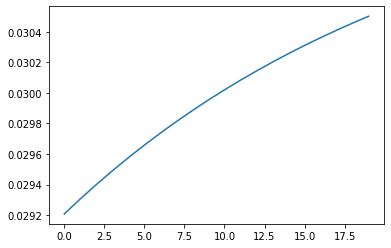

In [98]:
plt.plot(pred[:,0,0,0])

In [ ]:
# predict all data
n_steps = TIME_STEPS
split_point = 250
test_num = 250
for test_num in range(split_point,len(s)-(n_steps+1)):
    
    
    all_df = pd.DataFrame()
    for i in range(test_num,len(s)-(n_steps+1)+50):
        if i == test_num:
            batch_index = np.arange(i,i+1)
            batch = ts.get_one_batch(batch_index, n_steps)  # next_batch(self, batch_num, n_steps):
        else:
            a = np.array(batch[1]).reshape( n_steps)
            a = np.append(a,pred)
            input_data = np.array(a)
            batch = tuple([input_data[:-1].reshape(-1, n_steps, 1), input_data[1:].reshape(-1, n_steps, 1)]) 
        tot_res = get_predict(dp_model,batch)
        pred = tot_res.loc[TIME_STEPS-1,"mu"]
        all_df = pd.concat([all_df,tot_res], axis = 0)

    #  save 
    predict_df = all_df.loc[all_df.index.values == n_steps-1, :]
    predict_df = predict_df.reset_index(drop = True)
    predict_df.to_csv("./output/predict_num/result_test_DeepAR_"+ str(test_num) +".csv",index = False)

D:\Users\admin\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


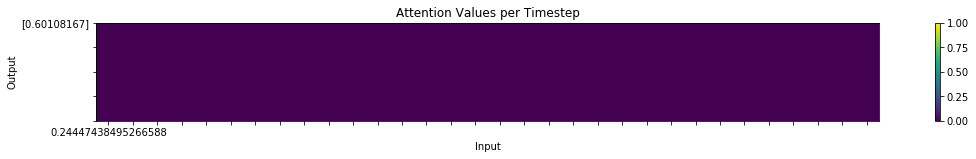

In [59]:
i = random.randint(0, data_len-Ty-Ty)
human_vocab = np.arange(human_vocab_size)

def plot_attention_graph(model, x, Tx, Ty, human_vocab, layer=7):
    # Process input
#     tokens = np.array([tokenize(x, human_vocab, Tx)])
#     tokens_oh = oh_2d(tokens, len(human_vocab))
    i = random.randint(0, len(x))
    tokens_oh = [X[i:i+1]]
    
    # Monitor model layer
    layer = model.layers[layer]
    
    layer_over_time = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    layer_output = layer_over_time([tokens_oh])
    layer_output = [row.flatten().tolist() for row in layer_output]
    
    # Get model output
    prediction = get_prediction(model, tokens_oh)[1]
    
    # Graph the data
    fig = plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(1.8)
    ax = fig.add_subplot(111)
    
    plt.title("Attention Values per Timestep")
    
    plt.rc('figure')
    cax = plt.imshow(layer_output, vmin=0, vmax=1)
    fig.colorbar(cax)
    
    plt.xlabel("Input")
    ax.set_xticks(range(Tx))
    ax.set_xticklabels(x)
    
    plt.ylabel("Output")
    ax.set_yticks(range(Ty))
    ax.set_yticklabels(prediction)
    
    plt.show()
    
plot_attention_graph(model, X[i][0], Tx, Ty, human_vocab)